In [29]:
# !pip install yfinance
# !pip install scikit-learn

In [1]:
###Importing libraries
import pandas as pd
import numpy as np
import yfinance as yf  # We will use this library to upload latest data from Yahoo API
import os, sys
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
#currentdir = os.path.dirname(os.path.realpath(__file__))
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
# Importing custom functions
from src.data_collection import get_stock_data
from src.model_building import perform_linear_regression, perform_tuned_regression,train_xgboost_model_tuned,train_xgboost_model
from src.data_preprocessing import preprocess_stock_data
from src.feature_engineering import cal_ex_moving_avg, calculate_rsi
from src.model_evaluation import evaluate_model
from src.utils import save_model,save_raw_data,save_processed_data

In [2]:
# Function to get stock data
def get_stock_df(stock_name, period):
    """This functions helps in getting the stock data 
    from yahoo finance API"""
    stock_df = get_stock_data(stock_name, period)
    return stock_df

In [3]:
# Function to calculate momentum and plot buy/sell signals
def calculate_momentum(stock_data):
    """
    Calculate the momentum of stock data.

    Parameters:
    - stock_data (DataFrame): DataFrame containing stock data with a 'Close' column.

    Returns:
    - DataFrame: Original DataFrame with an added 'momentum' column representing the percentage change in closing prices.
    """
    stock_data['momentum'] = stock_data['Close'].pct_change()
    return stock_data

In [4]:
def calculate_features(stock_data):
    """
    Calculate Exponential Moving Average (EMA) and Relative Strength Index (RSI) for stock data.

    Parameters:
    - stock_data (DataFrame): DataFrame containing stock data.

    Returns:
    - DataFrame: Original DataFrame with additional columns for EMA and RSI.
    """
    stock_data = cal_ex_moving_avg(stock_data, EMA_window=3)
    stock_data = calculate_rsi(stock_data, window_days=14)
    return stock_data


In [5]:
def split_data(stock_data):
    """
    Split stock data into training and testing sets.

    Parameters:
    - stock_data (DataFrame): DataFrame containing stock data with columns 'Open', 'High', 'Low', 'Volume', 'EMA', 'RSI', and 'Close'.

    Returns:
    - tuple: A tuple containing four elements - train_x (training features), test_x (testing features), train_y (training target), test_y (testing target).
    """
    x = stock_data[['Open', 'High', 'Low', 'Volume', 'EMA', 'RSI']]
    y = stock_data['Close']
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15, shuffle=False, random_state=0)
    return train_x, test_x, train_y, test_y

In [6]:
def df_plot(data, x, y, title="", xlabel='Date', ylabel='Value'):
    """
    Plot visualizations of stock data.

    Parameters:
    - data (DataFrame): DataFrame containing stock data.
    - x (array-like): X-axis data, typically representing dates.
    - y (array-like): Y-axis data, corresponding to the values to be plotted.
    - title (str): Title of the plot (default is an empty string).
    - xlabel (str): Label for the X-axis (default is 'Date').
    - ylabel (str): Label for the Y-axis (default is 'Value').
    - dpi (int): Dots per inch for the resolution of the plot (default is 100).

    Returns:
    - None
    """
    plt.figure(figsize=(10, 3))
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [7]:
stock_name = "NIO"
period = "2mo"

# Step 1: Get stock data
stock_data = get_stock_df(stock_name, period)
print(stock_data.shape)
stock_data.head(5)

NIO 2mo
(41, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-02-09 00:00:00-05:00,5.84,5.93,5.75,5.93,25563500,0.0,0.0
1,2024-02-12 00:00:00-05:00,5.91,6.28,5.90,6.08,43673000,0.0,0.0
2,2024-02-13 00:00:00-05:00,5.86,5.88,5.65,5.70,52054400,0.0,0.0
3,2024-02-14 00:00:00-05:00,5.88,6.02,5.84,6.00,41176800,0.0,0.0
4,2024-02-15 00:00:00-05:00,6.05,6.29,6.04,6.09,54076700,0.0,0.0


In [8]:
data_dir = "D:/Python/Stock_price_prediction/Stock_price_prediction/data/raw"

In [9]:
save_raw_data(stock_data,stock_name,data_dir)

Raw data saved successfully as: D:/Python/Stock_price_prediction/Stock_price_prediction/data/raw\NIO_raw_data.csv


In [10]:
# Step 2: Preprocess stock data
stock_data = preprocess_stock_data(stock_data)

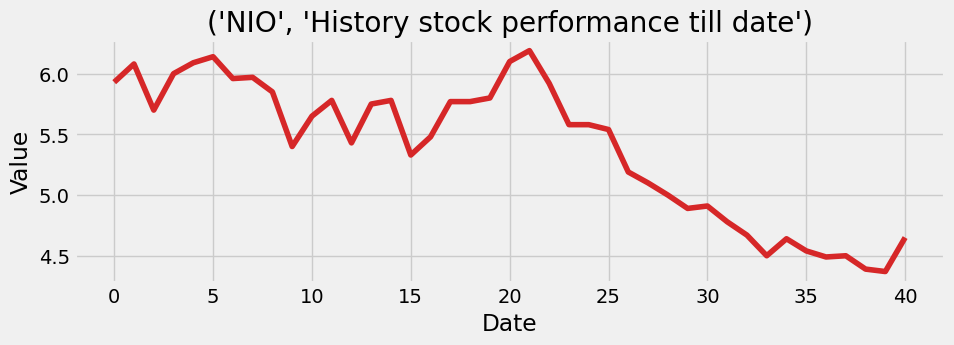

In [11]:
# Step 3: Plot stock data
df_plot(stock_data, stock_data.index, stock_data['Close'], title=(stock_name, "History stock performance till date"))

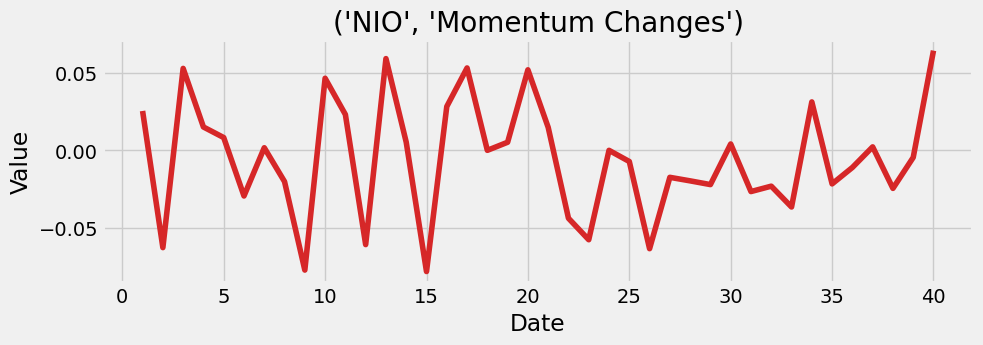

In [12]:
# Step 4: Calculate momentum and plot buy/sell signals
stock_data = calculate_momentum(stock_data)
df_plot(stock_data, stock_data.index, stock_data['momentum'], title=(stock_name, "Momentum Changes"))

In [13]:
# Step 5: Calculate EMA and RSI
stock_data = calculate_features(stock_data)
stock_data.head(5)

,Open,High,Low,Close,Volume,momentum,EMA,Price_Change,Gain,Loss,Avg_Gain,Avg_Loss,RS,RSI
13,5.56,5.79,5.54,5.75,63187100,0.058932,5.661930,0.32,0.32,0.00,0.092857,0.105714,0.878378,46.762593
14,5.73,5.84,5.68,5.78,40933100,0.005217,5.720965,0.03,0.03,0.00,0.095000,0.105714,0.898649,47.330968
15,5.58,5.61,5.25,5.33,94275800,-0.077855,5.525482,-0.45,0.00,0.45,0.084286,0.137857,0.611399,37.942125
16,5.17,5.62,4.78,5.48,94784600,0.028143,5.502741,0.15,0.15,0.00,0.095000,0.110714,0.858065,46.180560
17,5.39,5.88,5.38,5.77,77698800,0.052920,5.636371,0.29,0.29,0.00,0.094286,0.110714,0.851613,45.993032


In [14]:
data_dir = "D:/Python/Stock_price_prediction/Stock_price_prediction/data/processed"
save_processed_data(stock_data,stock_name,data_dir)

Processed data saved successfully as: D:/Python/Stock_price_prediction/Stock_price_prediction/data/processed\NIO_processed_data.csv


In [15]:
# Step 6: Split data into training and testing sets
train_x, test_x, train_y, test_y = split_data(stock_data)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(23, 6)
(5, 6)
(23,)
(5,)


In [16]:
# Step 7: Perform linear regression without hyperparameter tuning
model_before_tuning, X_train, X_test, y_train, y_test = perform_linear_regression(train_x, test_x, train_y,test_y)

# Make predictions
predicted_prices_before_tuning = model_before_tuning.predict(X_test)

# Evaluate model
evaluation_metrics_before_tuning = evaluate_model(y_test, predicted_prices_before_tuning)

In [17]:
# Step 8: Evaluate results before tuning
print("Results before hyperparameter tuning:")
print("Evaluation metrics before tuning:")
print("Confidence (R-squared) before tuning:", evaluation_metrics_before_tuning["R-squared Score"])
print("Mean Squared Error before tuning:", evaluation_metrics_before_tuning["Mean Squared Error"])
print("Mean Absolute Percentage Error (MAPE) before tuning:", evaluation_metrics_before_tuning["Mean Absolute Percentage Error (MAPE)"])


Results before hyperparameter tuning:
Evaluation metrics before tuning:
Confidence (R-squared) before tuning: 0.805177806193767
Mean Squared Error before tuning: 0.0019313128862350933
Mean Absolute Percentage Error (MAPE) before tuning: 0.7973019467305267


In [18]:
# Step 9: Perform linear regression with hyperparameter tuning
model_after_tuning, confidence_after_tuning_lr, predicted_prices_after_tuning, evaluation_metrics_after_tuning = perform_tuned_regression(train_x, test_x, train_y, test_y)

# Step 10: Evaluate results after tuning
print("\nResults after hyperparameter tuning:")
print("Confidence (R-squared) after tuning:", confidence_after_tuning_lr)
print("Mean Squared Error after tuning:", evaluation_metrics_after_tuning["Mean Squared Error"])
print("Mean Absolute Percentage Error (MAPE) after tuning:", evaluation_metrics_after_tuning["Mean Absolute Percentage Error (MAPE)"])




Results after hyperparameter tuning:
Confidence (R-squared) after tuning: 0.7635502983305821
Mean Squared Error after tuning: 0.002343975020806794
Mean Absolute Percentage Error (MAPE) after tuning: 1.0304025526170446


c:\Users\hits-\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.18957e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\hits-\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.55273e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\hits-\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.41874e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\hits-\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.42714e-17): result may not be accurate.
  return linalg.solve

In [19]:
# Train the XGBoost model
trained_model, X_train_used, y_train_used, X_test_used, y_test_used = train_xgboost_model(X_train, y_train, X_test, y_test)

# Predict the test data
y_pred = trained_model.predict(X_test_used)

# Evaluate the trained model using your evaluate_model function
evaluation_metrics_before_tuning_xgb = evaluate_model(y_test_used, y_pred)

# Print or use the evaluation results as needed
print("XGBoost Results before hyperparameter tuning:")
print("Evaluation metrics before tuning:")
print("Confidence (R-squared) before tuning:", evaluation_metrics_before_tuning_xgb["R-squared Score"])
print("Mean Squared Error before tuning:", evaluation_metrics_before_tuning_xgb["Mean Squared Error"])
print("Mean Absolute Percentage Error (MAPE) before tuning:", evaluation_metrics_before_tuning_xgb["Mean Absolute Percentage Error (MAPE)"])


XGBoost Results before hyperparameter tuning:
Evaluation metrics before tuning:
Confidence (R-squared) before tuning: -0.831125065862387
Mean Squared Error before tuning: 0.018152323238518876
Mean Absolute Percentage Error (MAPE) before tuning: 2.7573690289067634


In [20]:
### Define the hyperparameters grid for tuning
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    # 'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
    # 'reg_lambda': [0, 0.1, 0.5, 1] 
}

In [21]:
###Training XGBOOST with hyperparameters
res_tuple = train_xgboost_model_tuned(X_train, y_train, X_test, y_test, params)
best_model, best_params = res_tuple[:2]  # Extract the first two elements

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [22]:
####predicting on X test data
y_pred = best_model.predict(X_test)

In [23]:
###evaluate the best model separately using your evaluate_model function
evaluation_metrics_after_tuning_xgb = evaluate_model( y_test,y_pred)

# Print or use the evaluation metrics as needed
print("Evaluation Metrics:")
print("\nResults after hyperparameter tuning:")
print("Confidence (R-squared) after tuning:", evaluation_metrics_after_tuning_xgb['R-squared Score'])
print("Mean Squared Error after tuning:", evaluation_metrics_after_tuning_xgb["Mean Squared Error"])
print("Mean Absolute Percentage Error (MAPE) after tuning:", evaluation_metrics_after_tuning_xgb["Mean Absolute Percentage Error (MAPE)"])

Evaluation Metrics:

Results after hyperparameter tuning:
Confidence (R-squared) after tuning: -0.12439562801649728
Mean Squared Error after tuning: 0.011146367480978369
Mean Absolute Percentage Error (MAPE) after tuning: 2.095771396506922


In [24]:
# Define the results and model names
model_names = ['Linear Before Tuning', 'Linear After Tuning', 'XGBoost Before Tuning', 'XGBoost After Tuning']
mse_values = [evaluation_metrics_before_tuning["Mean Squared Error"], evaluation_metrics_after_tuning["Mean Squared Error"],
              evaluation_metrics_before_tuning_xgb["Mean Squared Error"], evaluation_metrics_after_tuning_xgb["Mean Squared Error"]]
confidence_values = [evaluation_metrics_before_tuning['R-squared Score'], evaluation_metrics_after_tuning['R-squared Score'],evaluation_metrics_before_tuning_xgb["R-squared Score"] ,evaluation_metrics_after_tuning_xgb['R-squared Score'] ]  # Fill in with actual confidence values
mape_values = [evaluation_metrics_before_tuning["Mean Absolute Percentage Error (MAPE)"], evaluation_metrics_after_tuning["Mean Absolute Percentage Error (MAPE)"],
               evaluation_metrics_before_tuning_xgb["Mean Absolute Percentage Error (MAPE)"], evaluation_metrics_after_tuning_xgb["Mean Absolute Percentage Error (MAPE)"]]

# Create DataFrame
results_df = pd.DataFrame({
    'Model Name': model_names,
    'MSE': mse_values,
    'Confidence (R-squared)': confidence_values,
    'MAPE': mape_values
})

# Print the DataFrame
print(results_df)

              Model Name       MSE  Confidence (R-squared)      MAPE
0   Linear Before Tuning  0.001931                0.805178  0.797302
1    Linear After Tuning  0.002344                0.763550  1.030403
2  XGBoost Before Tuning  0.018152               -0.831125  2.757369
3   XGBoost After Tuning  0.011146               -0.124396  2.095771


In [25]:
# Calculate the baseline MSE based on the minimum MSE among the models
baseline_mse = results_df['MSE'].min()

# Compare results and save the best model if it meets the criteria
best_model_name = results_df.loc[results_df['MSE'].idxmin(), 'Model Name']
best_model_mse = results_df.loc[results_df['MSE'].idxmin(), 'MSE']

# Get the best model object based on the best_model_name
if best_model_name == 'Linear Before Tuning':
    best_model = perform_linear_regression
elif best_model_name == 'Linear After Tuning':
    best_model = perform_tuned_regression
elif best_model_name == 'XGBoost Before Tuning':
    best_model = train_xgboost_model
elif best_model_name == 'XGBoost After Tuning':
    best_model = train_xgboost_model_tuned
else:
    best_model = None




In [28]:
model_dir = "D:\Python\Stock_price_prediction\Stock_price_prediction\models"
# Save the best model if it's not None
if best_model is not None:
    save_model(best_model, model_dir)
    print("Best model saved successfully.")
else:
    print("No improvement in model performance. Best model not saved.")

Model saved successfully as: D:\Python\Stock_price_prediction\Stock_price_prediction\models\best_model.pkl
Best model saved successfully.


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\hits-\AppData\Local\Temp\ipykernel_160\1802227296.py:1: SyntaxWarning: invalid escape sequence '\P'
  model_dir = "D:\Python\Stock_price_prediction\Stock_price_prediction\models"
